# Environments of the structures :

Essentially generates the figure 12 in our paper.

A notebook to study the environment of the structures found via our method.

[Stark et. al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.453..311S/abstract), shows the completeness even for the ideal map is not $100 \% $. What is exeptional about the detected structures ?

Points Stark 2015 have found in their paper :


- I have read the protocluster identification sections for  "ideal map and "mock surveys" in Stark 2015, they show the detected structures are different from field in terms of :

1. They contain more halos within themselves than the field.

2. The most massive halo within them are mote maassive than those within field.

What should we do in addition to that ?


-   The first step may be looking at the  density over larger scales.

-   Or finding the progenitors at $z=2.5$. 


In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as gf
import numpy as np
import importlib
plt.style.use('paper.mystyle')

## In True map :

The picture below from [this movie ](https://drive.google.com/file/d/1bzG6mf8stbM4Aplxt6d_blv7OJr6nwvm/view?usp=sharing) Shows sth interesting :

1. The undetected structures are isolated, they have very few progenitors around them. But the detected ones are an accumulation of the progenitors.

2. Since the flux map indeed indeed tracers the density on cMpc scales, the criterion to be detected is being dense enoguh. 

  Therefore, maybe the only way to be dense enough at $z \sim 2.5$ is to have many nearby massive progenitors.

![](./figures/undetected_sample.png)

Quanitifying this :


In [22]:
def get_detected_progs(lmap, peaks, mlim=[13.5, np.inf]):
    """Find and count the detected progenitors more massive than mlim"""
    #parentid = peaks['parentid'][:]
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where((Mass > mlim[0])*(Mass < mlim[1]))[0]
    indm = np.isin(fcofm['cluster_ind'][:], indm, assume_unique=True)
    prog = np.zeros((205,205,205))
    x, y, z = fcofm['x'][:][indm].astype(int), fcofm['y'][:][indm].astype(int), fcofm['z'][:][indm].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:][indm]+1
    
    detected_progs, peakid = np.array([]), np.array([])
    
    for i in range(1,peaks['x'].size+1):
        contour = np.zeros((205,205,205), dtype=int)
        contour[lmap==i] = 1
        overlap_progs = np.unique(prog*contour).astype(int)[1::]
        # Return the prog counting to start from 0 (index of the cluster at z=0)
        detected_progs = np.append(detected_progs, overlap_progs-1)
        peakid = np.append(peakid, np.ones_like(overlap_progs)*i)
        
    return detected_progs, peakid

In [23]:
%%time
detected_progs, peakids = get_detected_progs(
    lmap = h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/labeled_map_TNG_true_z2.4_n1_sigma4_th2.35_lc2.00.hdf5',
                     'r')['map'][:],
    peaks= h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/peaks_TNG_true_z2.4_n1_sigma4_th2.35_lc2.00.hdf5',
                     'r'))

CPU times: user 31.3 s, sys: 2.89 s, total: 34.2 s
Wall time: 34.3 s


## Large-scale Over-density:

Plot $M_{desc}(z=0) $ vs mean DM density whitin a tophat filter for the detected and undetected structures.

In [3]:
def large_over_density(detected_progs, z=2.4442257045541464, r=4):
    from codes import minima
    from astropy.cosmology import Planck15 as cosmo
    
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    DMconv = gf(h5py.File('../LyTomo_data/DM_Density_field/TNG_DM_z2.4.hdf5',
                          'r')['DM/dens'][:], sigma=4, mode='wrap')
    x, y, z = fcofm['x'][:].astype(int), fcofm['y'][:].astype(int), fcofm['z'][:].astype(int)
    
    def _iterate_over_structs(ClusterInd):
        """Iterate over clusters and save the mass in Mass"""
        MeanDens = np.array([])
        for c, d in enumerate(ClusterInd):
            neighbourhood = np.zeros((205,205,205), dtype=int)
            ind = np.where(fcofm['cluster_ind'][:]==d)[0]
            xn, yn, zn = minima.tophat_mask(x[ind], y[ind], z[ind], Lx=205,
                                            Ly=205, Lz=205, maxrad=r)
            neighbourhood[xn, yn, zn] = 1
            #DMMeanDen_to_rhoc = (cosmo.Om0 + cosmo.Ob0) / cosmo.Om0
            MeanDens = np.append(MeanDens, np.sum(DMconv*neighbourhood)/xn.size)  
        return MeanDens
        
    DeltaMean_det = _iterate_over_structs(ClusterInd=detected_progs)
    
    undetected_progs = np.array(list(set(fcofm['cluster_ind'][:]) 
                                     - set(detected_progs)))
    DeltaMean_un = _iterate_over_structs(ClusterInd=undetected_progs)
        
    return DeltaMean_det, DeltaMean_un

In [4]:
def plotMdec_Msph(detected_progs, DeltaMean_det, DeltaMean_un):
    # Setup the figure
    importlib.reload(plt)
    plt.style.use('paper.mystyle')
    left, width = 0.15, 0.60
    bottom, height = 0.1, 0.60
    spacing = 0
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    # Plotting part
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    undetected_progs = np.array(list(set(fcofm['cluster_ind'][:]) 
                                     - set(detected_progs)))
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5','r')
    Mass = np.log10(all_clusters['Mass'][:])+10

    
    print(DeltaMean_un.size, undetected_progs.size)
    print(DeltaMean_det.size, detected_progs.size)
    ax.scatter(DeltaMean_un, Mass[undetected_progs.astype(int)], marker='s',
               s=150, facecolor='w', edgecolor='C1', alpha=0.7, label='undetected', linewidth=3)
    ax.scatter(DeltaMean_det, Mass[detected_progs.astype(int)], marker='o',
               s=150, facecolor='w', edgecolor='C0', alpha=0.4, label='detected', linewidth=3)
    ax.grid(True, alpha=0.6)
    ax.legend()
    
    ax_histx.hist(DeltaMean_det, histtype='step', label='Detected')
    ax_histx.hist(DeltaMean_un, histtype='step', ls='--', label='Undetected')
    ax_histx.legend(loc=(1.01,0.5))
    ax_histx.set_yticks([50,150,300])
    
    ax_histy.hist(Mass[detected_progs.astype(int)], histtype='step',
                  orientation='horizontal')
    ax_histy.hist(Mass[undetected_progs.astype(int)], histtype='step',
                  orientation='horizontal', ls='--')
    ax_histy.set_xticks([50,150, 300])
    
    ax.set_xlabel(r'$\rm \frac{<\rho_{DM}>_{4 cMpc/h}}{<\rho_{DM}>} $', fontsize=45)
    ax.set_ylabel(r'$\rm M_{z=0} \ (h^{-1} \  M_{\odot})$')
    plt.tight_layout()
    #plt.suptitle('r = '+str(r), fontsize=40)
    

766 766
326 326


<ipython-input-20-169790efafca>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-22-ce2228d919bf>:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


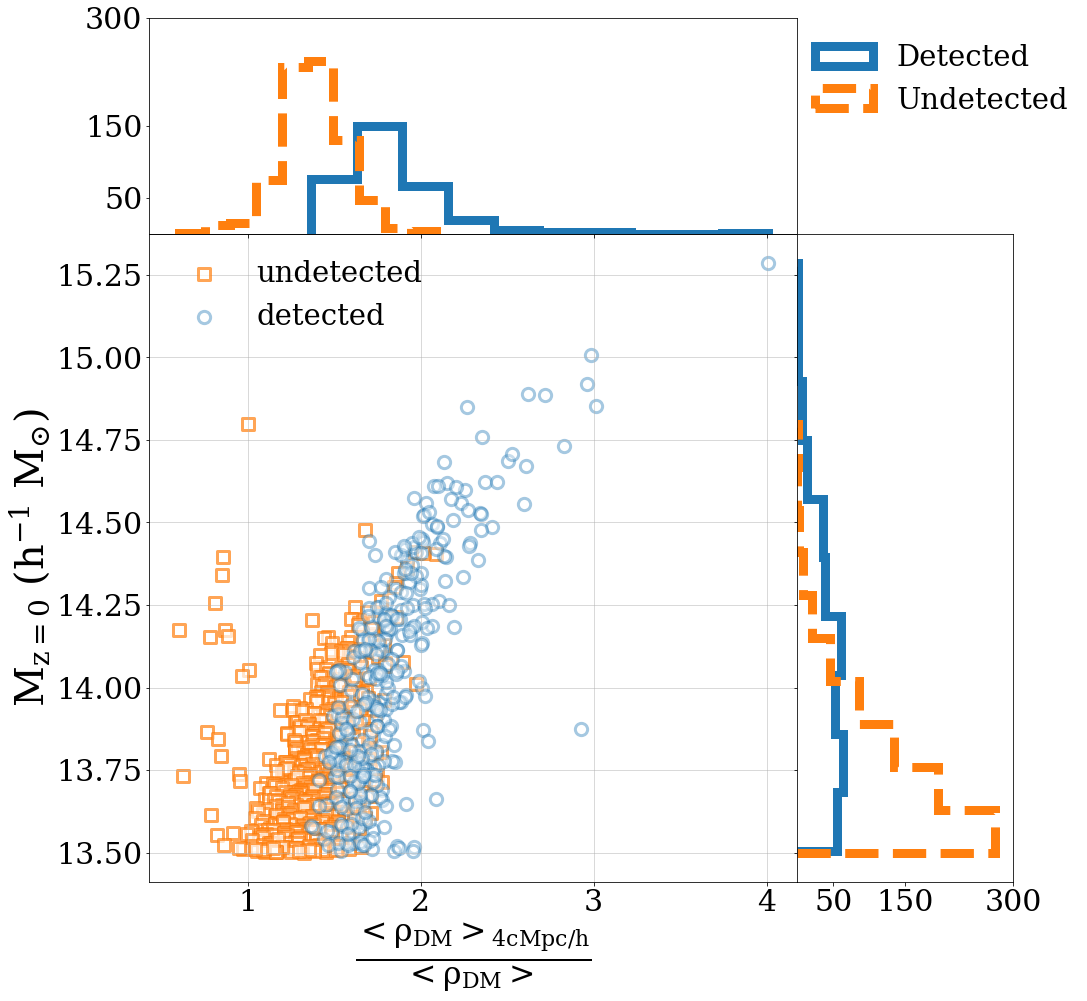

In [22]:
DeltaMean_det, DeltaMean_un = large_over_density(detected_progs, r=4)
plotMdec_Msph(detected_progs, DeltaMean_det, DeltaMean_un)
plt.tight_layout()
plt.savefig('./figures/un_detected_M0_Mtophat.pdf', transparent=True)

Checking the sensitivity to the top-hat radius :

766 766
326 326


<ipython-input-20-169790efafca>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


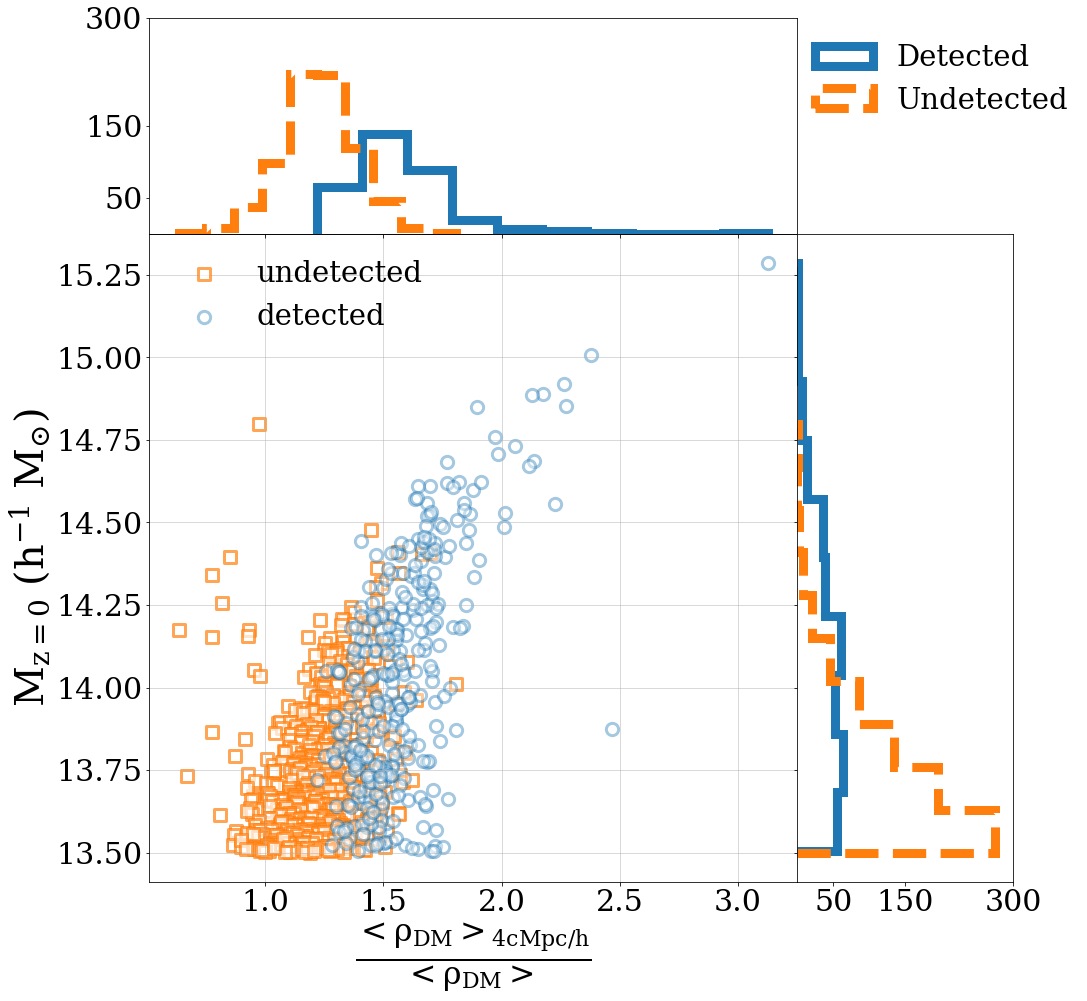

In [23]:
DeltaMean_det, DeltaMean_un = large_over_density(detected_progs, r=7)
plotMdec_Msph(detected_progs, DeltaMean_det, DeltaMean_un)

**Conclusion** : The detcted progenitors are within denser regions at z = 2.5 than the undetected ones.

- The overlp :At const M(z=0), if the environment is very (ubder-)dense , the object is (un-)detectable. But in between, sth else should dictate wheter they are detectable. It might be baryonic effects. So, Below, we check the map generated by applying FGPA on DM-only snapshot.

### With FGPA :

In [7]:
%%time
detected_progs_fgpa, _ = get_detected_progs(
    lmap = h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/lmap_FGPA_TNG_true_z2.4.hdf5',
                     'r')['map'][:],
    peaks= h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/peaks_FGPA_TNG_true_z2.4.hdf5',
                     'r'))

CPU times: user 31.4 s, sys: 2.95 s, total: 34.4 s
Wall time: 34.5 s


<ipython-input-4-169790efafca>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


759 759
333 333


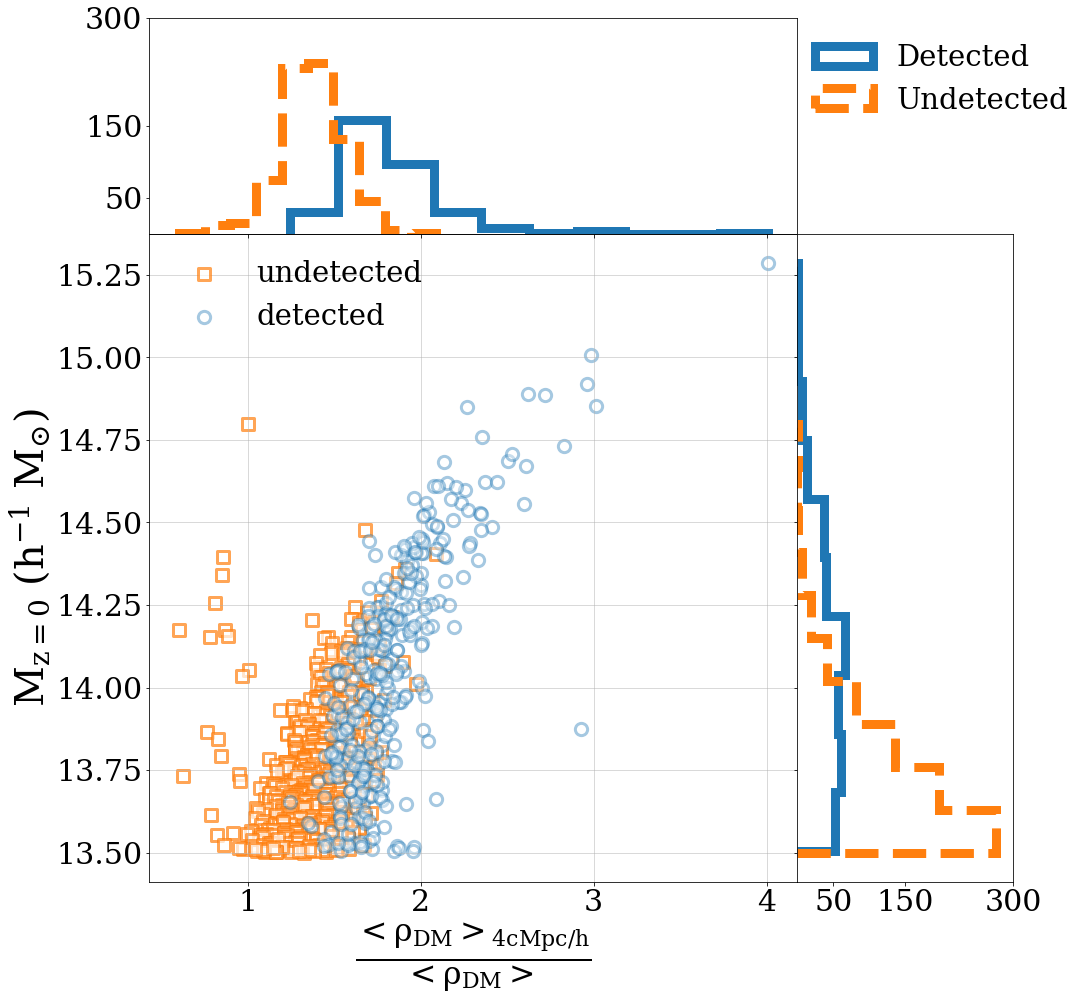

In [9]:
DeltaMean_det, DeltaMean_un = large_over_density(detected_progs_fgpa, r=4)
plotMdec_Msph(detected_progs_fgpa, DeltaMean_det, DeltaMean_un)

- The overlap is not much different than Hydro results. 

   Therefore, the mixture of the detected and undetectd structures cannot be explained by any baryoinic or feedback effects.

### The signifincae of the detected progs:

In [11]:
def plotMdec_Msph(detected_progs, peakids, DeltaMean_det, DeltaMean_un, peaks):
    # Setup the figure
    importlib.reload(plt)
    plt.style.use('paper.mystyle')
    left, width = 0.15, 0.60
    bottom, height = 0.1, 0.60
    spacing = 0
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    # Plotting part
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5','r')
    undetected_progs = np.array(list(set(fcofm['cluster_ind'][:]) - set(detected_progs)))
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5','r')
    Mass = np.log10(all_clusters['Mass'][:])+10

    
    print(DeltaMean_un.size, undetected_progs.size)
    print(DeltaMean_det.size, detected_progs.size)
    # The significance of the watersheds the progenitors lay within
    signif = peaks['signif'][:][peakids.astype(int)-1]
    ind1 = (signif > -2.5)*(signif < -2.0)
    ind2 = (signif > -3.0)*(signif < -2.5)
    ind3 = (signif > -3.5)*(signif < -3.0)
    ind4 = (signif < -3.5)
    ind = [ind1, ind2, ind3, ind4]
    colors = ['C0', 'C2', 'C3', 'C4']
    label = ['-2.35,-2.5','-2.5,-3.0','-3.0,-3.5','<-3.5']
    marker = ['o','s','*','^']
    ls = ['solid', '--', 'dotted', '-.']
    for i in range(4):
        ax.scatter(DeltaMean_det[ind[i]], Mass[detected_progs.astype(int)][ind[i]],
                   marker=marker[i], s=75, facecolor='w', edgecolor=colors[i], 
                   alpha=0.4, label=label[i], linewidth=3)
        ax_histx.hist(DeltaMean_det[ind[i]], histtype='step', label=label[i],
                      ls=ls[i], lw=4, bins=np.arange(1,3,0.2))
        ax_histy.hist(Mass[detected_progs.astype(int)][ind[i]], histtype='step',
                      orientation='horizontal', ls=ls[i], lw=4,
                      bins=np.arange(13.5,15.25, 0.2))
    ax.grid(True, alpha=0.6)
    ax.legend()
    ax.set_xlim((1,3))
    
    
    #ax_histx.hist(DeltaMean_un, histtype='step', ls='--', label='Undetected')
    ax_histx.legend(loc=(1.01,0.5))
    #ax_histx.set_yticks([50,150,300])
    
    
    #ax_histy.hist(Mass[undetected_progs.astype(int)], histtype='step', orientation='horizontal', ls='--')
    #ax_histy.set_xticks([50,150, 300])
    
    ax.set_xlabel(r'$\rm \frac{<\rho_{DM}>_{4 cMpc/h}}{<\rho_{DM}>} $', fontsize=45)
    ax.set_ylabel(r'$\rm M_{z=0} \ (h^{-1} \  M_{\odot})$')
    plt.tight_layout()
    #plt.suptitle('r = '+str(r), fontsize=40)
    

766 766
326 326


<ipython-input-11-ed81e26b09e5>:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-15-bc448d00aea2>:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


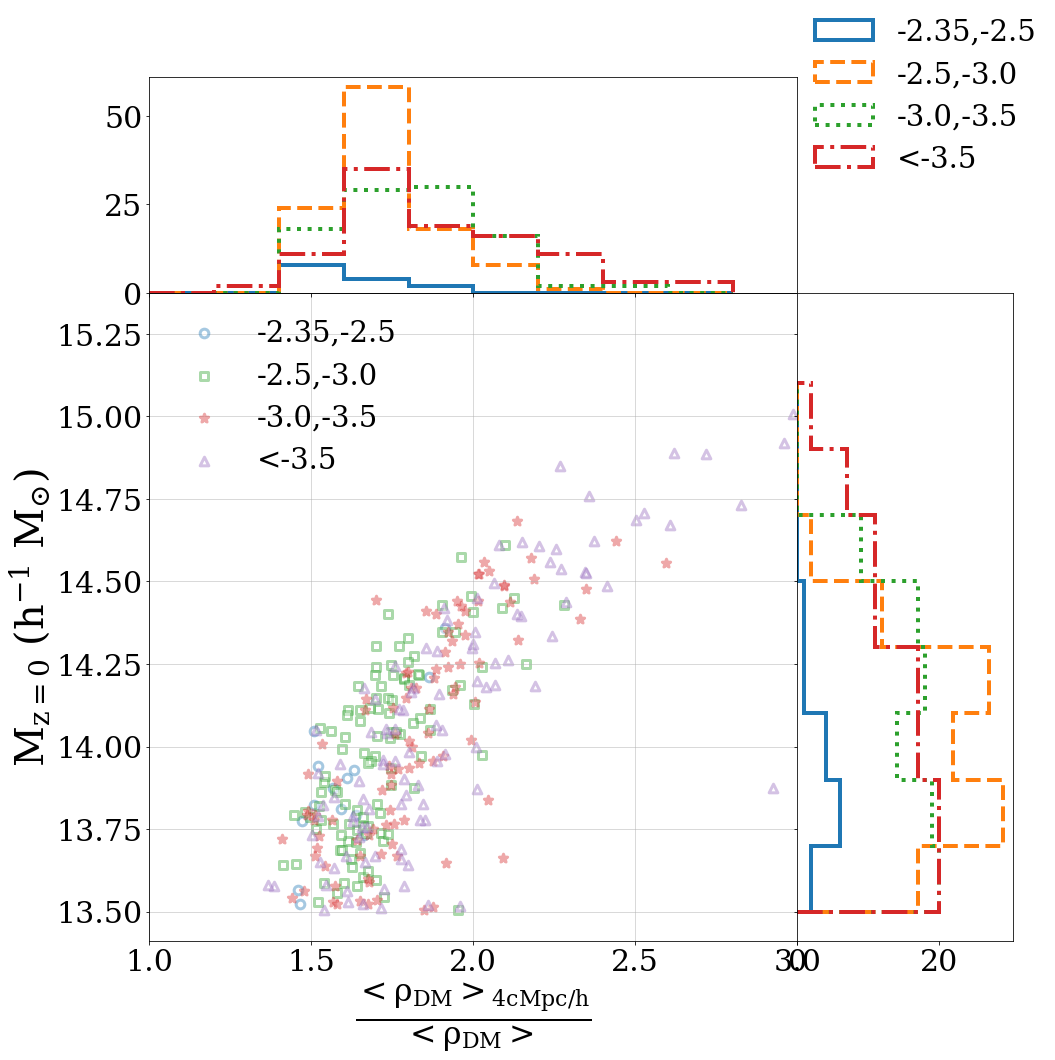

In [15]:
DeltaMean_det, DeltaMean_un = large_over_density(detected_progs, r=4)
plotMdec_Msph(detected_progs, peakids,DeltaMean_det, DeltaMean_un,
              peaks= h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/peaks_TNG_true_z2.4_n1_sigma4_th2.35_lc2.00.hdf5',
                               'r'))
plt.tight_layout()
plt.savefig('./figures/bias_det_progenitor_signif.png')

## Completeness desc vs prog method:

Now check what would have got if we used the detected -vs- undetected progenitor numbers to constrain the completeness rather finding the descendants of the watersheds. \
The figure below shows eventhough we only have the progenitors for z=0 halos with $M(z=0) > 10^{13.5} \ M_{\odot}/h$, the completness seems more or less the same in both approaches!

In [19]:
# For mock map
detected_progs_mock, _ = get_detected_progs(
    lmap = h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n1/labeled_map_TNG_z2.4_n1_sigma4_th2.35_lc2.00.hdf5',
                     'r')['map'][:],
    peaks= h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n1/peaks_TNG_z2.4_n1_sigma4_th2.35_lc2.00.hdf5',
                     'r'))

In [46]:
def plot_completeness(detected_progs, detected_progs_mock):
    """Use progenitors to check the completness"""
    plt.style.use('Notebook.mystyle')
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    bins= np.arange(13.5,15.75, 0.25)
    all_clusters = h5py.File('../LyTomo_data/progenitors/clusters_TNG300-1.hdf5',
                             'r')
    fcofm = h5py.File('../LyTomo_data/progenitors/cofm_progenitors.hdf5',
                      'r')
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where(Mass > 13.5)[0]
    # Halo mas function
    hmf = ax[0].hist(Mass[indm], bins=bins, histtype='step', label='HMF')
    # For true map
    hmf_det = ax[0].hist(Mass[detected_progs.astype(int)], bins=bins, histtype='step',
                         ls='--', label='prog true map')
    # For mock map
    hmf_det_mock = ax[0].hist(Mass[detected_progs_mock.astype(int)], bins=bins,
                              histtype='step', ls='--', label='prog mock map')
    
    # Descendant method 
    f = h5py.File('../LyTomo_data/plotting_data/completenss_mock_z2.4.hdf5','r')
    hmf_det_desc = ax[0].hist(np.repeat(f['mbins'][:],f['cmock'][:].astype(int)), histtype='step',
                              label='desc mock map', bins=f['bins'][:], ls='dotted')
    
    ax[0].set_yscale('log')
    ax[0].set_xlabel('FF Group Mass (z=0)')
    ax[0].set_ylabel('count')
    ax[0].legend()
    mbin = [(hmf_det[1][i]+hmf_det[1][i+1])/2 for i in range(hmf_det[1].size-1)]
    ax[1].plot(mbin, hmf_det[0]/hmf[0], marker='s', label='prog true map')
    ax[1].plot(f['mbins'][:], f['cmock'][:]/f['call'][:], marker='*', label='desc mock map', ls='-.')
    ax[1].plot(mbin, hmf_det_mock[0]/hmf[0], marker='^', label='prog mock map', ls='--')
    
    plt.plot(mbin, np.ones_like(mbin), ls='dotted')
    ax[1].legend()
    ax[1].set_xlabel('FOF Group Mass (z=0)')
    ax[1].set_ylabel('detected / true')

    
    
    

<ipython-input-46-a49ca3c20c53>:32: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(f['mbins'][:], f['cmock'][:]/f['call'][:], marker='*', label='desc mock map', ls='-.')


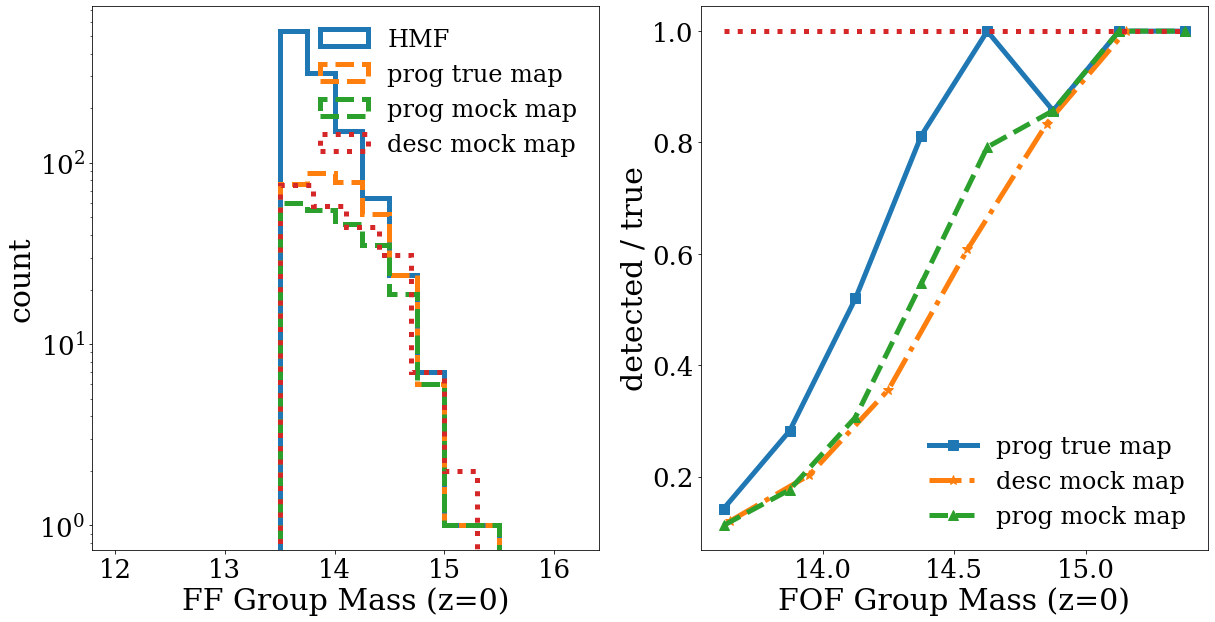

In [47]:
plot_completeness(detected_progs, detected_progs_mock)

Comparing the completeness in both methods applied on mock map the gareement is excelllent. But, we see  a slightly better completenss for prog method on lower mass bins.

- It is because in desc method we assign only and only 1 descendant to each subcontour, while in progenitor method we find multiple progenitors within some subcontours and it seems to be more likely for lower mass FOF Groups.